<a href="https://colab.research.google.com/github/bruno2siqueira/Machine_Learning/blob/main/Keras_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Baseado em https://www.pyimagesearch.com/2020/07/13/r-cnn-object-detection-with-keras-tensorflow-and-deep-learning/



# Importa os pré-requisitos

In [ ]:
# import the necessary packages
import os
# import the necessary packages
from bs4 import BeautifulSoup
from imutils import paths
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import os



In [ ]:
# Essa função não está sendo usada por enquanto
def compute_iou(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the intersection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

# Define variáveis do ambiente

In [ ]:
#Limite das probabilidades - se for menor então considera que o objeto não está na imagem
THRESHOLD = 0.1

#Número de classes
NRCLASSES = 15

#Nome da pasta
DATA_PATH="objetos-mesa"

#Dimensões da imagem que deve ser passada para a rede
INPUT_DIMS = (224, 224)
# define the path to the output model and label binarizer
MODEL_PATH = "object_detector.h5"
ENCODER_PATH = "label_encoder.pickle"
# define the minimum probability required for a positive prediction
# (used to filter out false-positive predictions)
MIN_PROBA = 0.99

#Variáveis para o treimanento
#Learning rate, qtdade de épocas e batch size
INIT_LR = 1e-4
EPOCHS = 100
BS = 32

MAX_PROPOSALS_INFER = 20

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Monta o google drive

In [ ]:
#Mount gdrive
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!ln -s gdrive/'My Drive'/'Object Detection Dataset'/'objetos-mesa' .

ln: failed to create symbolic link './objetos-mesa': File exists


In [ ]:
!ls

encoder  gdrive  modelo  objetos-mesa  sample_data


# Carrega as imagens

In [ ]:
#Inicializa os vetores que vão ser usados no treinamento
data = []
labels = []
image_count = 0

#Lê o arquivo index.txt que tem os prefixos das imagens e das anotações
f = open(DATA_PATH + os.path.sep + 'index.txt')
for linha in f:
  #Tira o \n no final de cada linha
	linha = linha[:-1]  
	print("[INFO] processing image ", linha)
	# extract the filename from the file path and use it to derive
	# the path to the XML annotation file

  #nome do arquivo da imagem
	imgFilename = DATA_PATH + os.path.sep + linha + '.jpg'

  # para fazer testes em um conjunto menor de imagens 
  # descomente as linhas a seguir pois isso irá carregar
  # um conjunto menor de imagens (6 somente)
	#image_count = image_count + 1
	#if (image_count > 5):
	#	break

  #nome do arquivo da anotação
	annotFilename = DATA_PATH + os.path.sep + linha + '.xml'
	
	# load the annotation file, build the soup, and initialize our
	# list of ground-truth bounding boxes
	contents = open(annotFilename).read()
	soup = BeautifulSoup(contents, "html.parser")

	# extract the image dimensions
	w = int(soup.find("width").string)
	h = int(soup.find("height").string)
	
	#continue

	# loop over all 'object' elements
	for o in soup.find_all("object"):
		# extract the label and bounding box coordinates
		label = o.find("name").string
		xMin = int(o.find("xmin").string)
		yMin = int(o.find("ymin").string)
		xMax = int(o.find("xmax").string)
		yMax = int(o.find("ymax").string)
		# truncate any bounding box coordinates that may fall
		# outside the boundaries of the image
		xMin = max(0, xMin)
		yMin = max(0, yMin)
		xMax = min(w, xMax)
		yMax = min(h, yMax)
		
  	# load the input image (224x224) and preprocess it
		image = load_img(imgFilename, target_size=INPUT_DIMS)
		image = img_to_array(image)
		image = preprocess_input(image)
  
    # a imagem é lida em 224x224 então é preciso calcular as dimensões
    # dos objetos anotados dentro dessa nova proporção de imagem
		ratio_w0 = round(w / INPUT_DIMS[0])
		ratio_h0 = round(h / INPUT_DIMS[1])
		xMin0 = round(xMin / ratio_w0)
		xMax0 = round(xMax / ratio_w0)
		yMin0 = round(yMin / ratio_h0)
		yMax0 = round(yMax / ratio_h0) 

    # seleciona a parte da imagem onde o objeto anotado está
		obj_image = image[yMin0:yMax0, xMin0:xMax0]

    # a entrada da rede espera uma imagem 224x224 então redimensiona o objeto
		obj_resized = resize(obj_image, (INPUT_DIMS[0], INPUT_DIMS[1]))
		
		data.append(obj_resized)
		labels.append(label)


[INFO] processing image  IMG_20201024_195603
[INFO] processing image  IMG_20201024_195611
[INFO] processing image  IMG_20201024_195621
[INFO] processing image  IMG_20201024_195727
[INFO] processing image  IMG_20201024_195733
[INFO] processing image  IMG_20201024_195741
[INFO] processing image  IMG_20201024_195842
[INFO] processing image  IMG_20201024_195848
[INFO] processing image  IMG_20201024_195855
[INFO] processing image  IMG_20201024_200118
[INFO] processing image  IMG_20201024_200132
[INFO] processing image  IMG_20201024_200249
[INFO] processing image  IMG_20201024_200253
[INFO] processing image  IMG_20201024_200257
[INFO] processing image  IMG_20201024_200306
[INFO] processing image  IMG_20201024_200345
[INFO] processing image  IMG_20201024_200351
[INFO] processing image  IMG_20201024_200357
[INFO] processing image  IMG_20201024_200422
[INFO] processing image  IMG_20201024_200427
[INFO] processing image  IMG_20201024_200431
[INFO] processing image  IMG_20201024_200432
[INFO] pro

In [ ]:
print(labels[0])

maionese


In [ ]:
data[0].shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


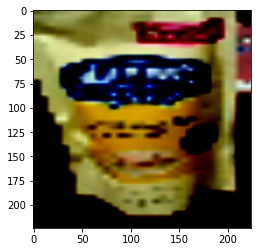

In [ ]:
plt.imshow(data[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


oleo
caixachocolate
agua
leite
pao
maionese
caixachocolate


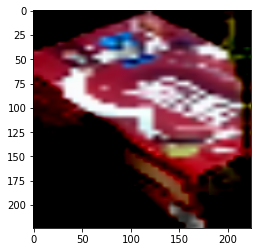

In [ ]:
for i in range(1,8):
  #print(i)
  print(labels[i])
  plt.imshow(data[i])

In [ ]:
# convert the data and labels to NumPy arrays
data_np = np.array(data, dtype="float32")
data_np.shape
labels_np = np.array(labels)
labels_np.shape
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels_b = lb.fit_transform(labels_np)
#Descomente a linha abaixo se o seu modelo só tem dois tipos de saída
#labels_b = to_categorical(labels_b)


In [ ]:
data_np.shape

(289, 224, 224, 3)

In [ ]:
labels_b.shape

(289, 15)

# Prepara o modelo

In [ ]:

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data_np, labels_b,
	test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(NRCLASSES, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
# TODO Testar com outras camadas não congeladas
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


# Treina o modelo

In [ ]:

EPOCHS=50
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/50
7/7 [==============================] - 14s 2s/step - loss: 3.5511 - accuracy: 0.0379 - val_loss: 2.8859 - val_accuracy: 0.1552
Epoch 2/50
7/7 [==============================] - 9s 1s/step - loss: 3.1410 - accuracy: 0.0887 - val_loss: 2.6308 - val_accuracy: 0.1897
Epoch 3/50
7/7 [==============================] - 10s 1s/step - loss: 2.8823 - accuracy: 0.1258 - val_loss: 2.4711 - val_accuracy: 0.2414
Epoch 4/50
7/7 [==============================] - 9s 1s/step - loss: 2.7563 - accuracy: 0.1297 - val_loss: 2.3607 - val_accuracy: 0.3621
Epoch 5/50
7/7 [==============================] - 10s 1s/step - loss: 2.5492 - accuracy: 0.1788 - val_loss: 2.2626 - val_accuracy: 0.3621
Epoch 6/50
7/7 [==============================] - 10s 1s/step - loss: 2.5190 - accuracy: 0.1870 - val_loss: 2.1732 - val_accuracy: 0.3966
Epoch 7/50
7/7 [==============================] - 9s 2s/step - loss: 2.3540 - accuracy: 0.2867 - val_loss: 2.0986 - val_accu

# Mostra as informações do treinamento

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
                 precision    recall  f1-score   support

           agua       1.00      0.50      0.67         4
         banana       1.00      1.00      1.00         4
 caixachocolate       0.50      0.50      0.50         2
            cha       0.80      1.00      0.89         4
     detergente       0.67      1.00      0.80         4
         feijao       0.00      0.00      0.00         2
        fosforo       1.00      0.80      0.89         5
          leite       0.71      1.00      0.83         5
leitecondensado       1.00      0.80      0.89         5
       maionese       0.83      1.00      0.91         5
           oleo       1.00      0.80      0.89         5
            pao       1.00      1.00      1.00         4
           pera       1.00      1.00      1.00         3
   refrigerante       1.00      0.50      0.67         2
       sucoempo       0.67      1.00      0.80         4

       accuracy                           0.84        58


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


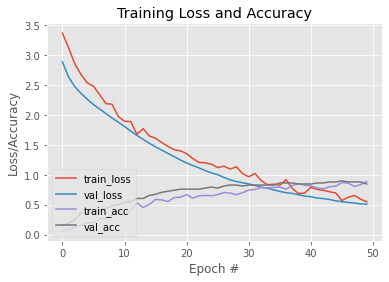

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])
plt.savefig('saida')

# Salvo o modelo

In [ ]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("modelo", save_format="h5")
# serialize the label encoder to disk
print("[INFO] saving label encoder...")
f = open("encoder", "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] saving mask detector model...
[INFO] saving label encoder...


In [ ]:
!ls

gdrive	objetos-mesa  sample_data


In [ ]:
!cp modelo objetos-mesa/modelo-30mar2021
!cp encoder objetos-mesa/encoder-30mar2021

In [ ]:
!ls objetos-mesa/

encoder-30mar2021	 IMG_20201024_200306.xml  IMG_20201024_200902.xml
IMG_20201024_195603.jpg  IMG_20201024_200345.jpg  IMG_20201024_200906.jpg
IMG_20201024_195603.xml  IMG_20201024_200345.xml  IMG_20201024_200906.xml
IMG_20201024_195611.jpg  IMG_20201024_200351.jpg  IMG_20201024_200935.jpg
IMG_20201024_195611.xml  IMG_20201024_200351.xml  IMG_20201024_200935.xml
IMG_20201024_195621.jpg  IMG_20201024_200357.jpg  IMG_20201024_200939.jpg
IMG_20201024_195621.xml  IMG_20201024_200357.xml  IMG_20201024_200939.xml
IMG_20201024_195727.jpg  IMG_20201024_200422.jpg  IMG_20201024_200944.jpg
IMG_20201024_195727.xml  IMG_20201024_200422.xml  IMG_20201024_200944.xml
IMG_20201024_195733.jpg  IMG_20201024_200427.jpg  IMG_20201024_201007.jpg
IMG_20201024_195733.xml  IMG_20201024_200427.xml  IMG_20201024_201007.xml
IMG_20201024_195741.jpg  IMG_20201024_200431.jpg  IMG_20201024_201011.jpg
IMG_20201024_195741.xml  IMG_20201024_200431.xml  IMG_20201024_201011.xml
IMG_20201024_195842.jpg  IMG_20201024_200432

# Carrega o modelo

Essa parte e a seguinte podem ser separadas em um programa a parte quando for usado em produção e/ou uma competição.
Como o treinamento está sendo feito logo acima não existe realmente necessidade de carregar o modelo.

Execute a célula abaixo se quiser carregar um modelo antigo

In [ ]:
!cp objetos-mesa/modelo-30mar2021 modelo
!cp objetos-mesa/encoder-30mar2021 encoder

In [ ]:
model = load_model("modelo")
lb = pickle.loads(open("encoder", "rb").read())

In [ ]:
!pwd

/content


In [ ]:
!ls

encoder  gdrive  modelo  objetos-mesa  sample_data


# Carrega uma imagem como exemplo e faz a predição

In [ ]:
#banana
#test_filename = 'IMG_20201109_195321'

test_filename = 'IMG_20201024_195842'

#pao e detergente
#test_filename = 'IMG_20201024_200717'

#test_filename = 'IMG_20201024_201140'
test_img = load_img('/content/objetos-mesa/'+test_filename+'.jpg', target_size=INPUT_DIMS)

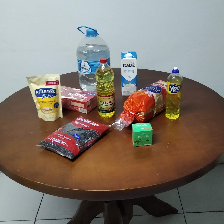

In [ ]:
test_img

In [ ]:
# Gera um vetor de entradas no qual será realizada a predição
test_img = img_to_array(test_img)
test_img = preprocess_input(test_img)
input_test = []

# TODO o ideal é preencher o vetor de entrada com porções da imagem
# assim podemos saber melhor onde estão localizados os objetos
# Sugestão: implementar o algoritmo de janela deslizante sobre a imagem
input_test.append(test_img)
input_test_np = np.array(input_test, dtype="float32")

# Salva as probabilidades para essa entrada em proba
proba = model.predict(input_test_np)

In [ ]:
proba

array([[0.23680383, 0.00576012, 0.0253812 , 0.00586112, 0.05499255,
        0.01256991, 0.04531718, 0.07796671, 0.00676787, 0.00205678,
        0.05849401, 0.25399855, 0.03229563, 0.17100248, 0.01073212]],
      dtype=float32)

In [ ]:
lb.classes_

array(['agua', 'banana', 'caixachocolate', 'cha', 'detergente', 'feijao',
       'fosforo', 'leite', 'leitecondensado', 'maionese', 'oleo', 'pao',
       'pera', 'refrigerante', 'sucoempo'], dtype='<U15')

In [ ]:
#Para o primeira imagem (posição 0) do vetor de entrada mostra
#as probabilidades caso elas sejam maiores do que o limite.
for prob_i, label_i in zip(proba[0], lb.classes_):
  if (prob_i > THRESHOLD):
    print(label_i, " ", prob_i)

agua   0.23680383
pao   0.25399855
refrigerante   0.17100248


# Até aqui parece estar funcionando 

A partir daqui parece que tem um ou mais bugs no código

# Testando com pedaços da imagem

In [ ]:
def max_prob_label(proba, labels):
  max_prob = 0
  max_label = ''

  for prob_i, label_i in zip(proba, labels):
    if (prob_i > max_prob):
      max_prob = prob_i
      max_label = label_i
  return [max_prob, max_label]


In [ ]:
data_np = np.array(data, dtype="float32")
data_np.shape

(289, 224, 224, 3)

In [ ]:
prob_test = model.predict(data_np)

In [ ]:
i = 4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


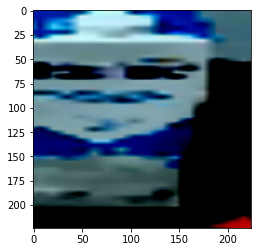

In [ ]:
plt.imshow(data[i])

In [ ]:
lb.classes_

array(['agua', 'banana', 'caixachocolate', 'cha', 'detergente', 'feijao',
       'fosforo', 'leite', 'leitecondensado', 'maionese', 'oleo', 'pao',
       'pera', 'refrigerante', 'sucoempo'], dtype='<U15')

In [ ]:
prob_test[i]

array([0.02357937, 0.00865029, 0.01642152, 0.00794489, 0.04986079,
       0.00423307, 0.00607117, 0.74092966, 0.00921768, 0.04361922,
       0.03988293, 0.01079168, 0.00830315, 0.02803945, 0.00245515],
      dtype=float32)

In [ ]:
max_prob_label(prob_test[i], lb.classes_)

[0.74092966, 'leite']

# Seletive search

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(test_img)
ss.switchToSelectiveSearchFast()
rects = ss.process()

In [ ]:
rects.shape

(305, 4)

In [ ]:
rects[0]

array([ 62, 121,  29,  16], dtype=int32)

In [ ]:
type(rects)

numpy.ndarray

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


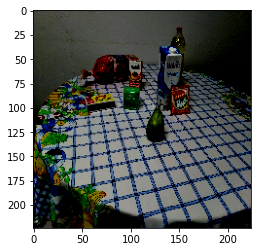

In [ ]:
plt.imshow(image)

In [ ]:
[x,y,w,h]=rects[0]
print(x,y,w,h)

62 121 29 16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


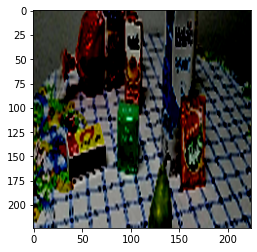

In [ ]:
roi = image[y:y + h, x:x + w]
#roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
roi = cv2.resize(roi, INPUT_DIMS,	interpolation=cv2.INTER_CUBIC)
plt.imshow(roi)

In [ ]:
# initialize the list of region proposals that we'll be classifying
# along with their associated bounding boxes
proposals = []
boxes = []
count = 0
# loop over the region proposal bounding box coordinates generated by
# running selective search
for rect in rects:
	count = count + 1
	# extract the region from the input image, convert it from BGR to
	# RGB channel ordering, and then resize it to the required input
	# dimensions of our trained CNN
	#if(count > MAX_PROPOSALS_INFER):
		#break

	[x, y, w, h] = rect
	roi = image[y:y + h, x:x + w]
	#roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
	roi = cv2.resize(roi, INPUT_DIMS, interpolation=cv2.INTER_CUBIC)
	# further preprocess the ROI
	#roi = img_to_array(roi)
	#roi = preprocess_input(roi)
	# update our proposals and bounding boxes lists
	proposals.append(roi)
	boxes.append((x, y, x + w, y + h))

In [ ]:
proposals

[array([[[ 0.58431375,  0.58431375,  0.5686274 ],
         [ 0.58431375,  0.58431375,  0.5686274 ],
         [ 0.58431375,  0.58431375,  0.5686274 ],
         ...,
         [ 0.5901971 ,  0.6013819 ,  0.578465  ],
         [ 0.5892024 ,  0.60061556,  0.5771113 ],
         [ 0.58950907,  0.60085183,  0.57752866]],
 
        [[ 0.58431375,  0.58431375,  0.5686275 ],
         [ 0.58431375,  0.58431375,  0.5686275 ],
         [ 0.58431375,  0.58431375,  0.5686275 ],
         ...,
         [ 0.59281266,  0.6035453 ,  0.57950264],
         [ 0.5917457 ,  0.6027124 ,  0.578074  ],
         [ 0.59207463,  0.6029693 ,  0.57851446]],
 
        [[ 0.58431375,  0.58431375,  0.5686274 ],
         [ 0.58431375,  0.58431375,  0.56862754],
         [ 0.58431375,  0.58431375,  0.56862754],
         ...,
         [ 0.5935332 ,  0.60414135,  0.57978857],
         [ 0.59244627,  0.60329014,  0.57833916],
         [ 0.5927815 ,  0.6035526 ,  0.578786  ]],
 
        ...,
 
        [[-0.19240315, -0.12782784

In [ ]:
proposals_np = np.array(proposals, dtype="float32")
boxes = np.array(boxes, dtype="int32")
print("[INFO] proposal shape: {}".format(proposals_np.shape))
# classify each of the proposal ROIs using fine-tuned model
print("[INFO] classifying proposals...")
proba = model.predict(proposals_np)

[INFO] proposal shape: (305, 224, 224, 3)
[INFO] classifying proposals...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


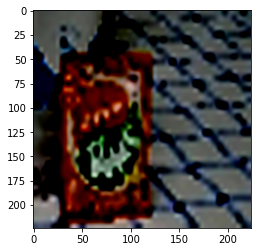

In [ ]:
i=1
plt.imshow(proposals[i])

In [ ]:
[tmp_prob, tmp_label] = max_prob_label(proba[i], lb.classes_)

In [ ]:
[tmp_prob, tmp_label]

[0.75005823, 'sucoempo']

In [ ]:
proba

array([[0.02743074, 0.01070907, 0.01438209, ..., 0.15255255, 0.00404757,
        0.07409471],
       [0.00209469, 0.00952977, 0.02087993, ..., 0.00692879, 0.00124381,
        0.75005823],
       [0.00777515, 0.07121337, 0.03971935, ..., 0.04113075, 0.01154175,
        0.03742221],
       ...,
       [0.06193591, 0.09594829, 0.00938163, ..., 0.4474878 , 0.0211847 ,
        0.04216958],
       [0.05619077, 0.10855328, 0.01422193, ..., 0.00737494, 0.02050315,
        0.01999019],
       [0.05559305, 0.03208999, 0.06482609, ..., 0.06280759, 0.00608396,
        0.21236846]], dtype=float32)

In [ ]:
scores = []
for prob_i in proba:
  max_val = np.max(prob_i)
  scores.append(max_val)

In [ ]:
scores

[0.3423751,
 0.75005823,
 0.23305948,
 0.18321647,
 0.2959221,
 0.27536163,
 0.55654687,
 0.3047216,
 0.39387065,
 0.34556863,
 0.34627095,
 0.3537997,
 0.14459041,
 0.31309265,
 0.33915588,
 0.28212976,
 0.3068838,
 0.28570685,
 0.4770144,
 0.27637368,
 0.17823409,
 0.23701788,
 0.41085383,
 0.16712609,
 0.4790204,
 0.32391477,
 0.25601614,
 0.5091841,
 0.61198103,
 0.33999825,
 0.57663685,
 0.23421995,
 0.1844678,
 0.20159933,
 0.22977704,
 0.28068104,
 0.5517264,
 0.5406304,
 0.24402809,
 0.30023518,
 0.27641037,
 0.23264156,
 0.22257304,
 0.36554524,
 0.17815647,
 0.26078218,
 0.408095,
 0.304591,
 0.38980663,
 0.3360541,
 0.25136834,
 0.21601062,
 0.45536378,
 0.43373773,
 0.30300704,
 0.44183674,
 0.39952525,
 0.26670355,
 0.30076566,
 0.3714535,
 0.2162073,
 0.21292998,
 0.43493006,
 0.47028074,
 0.384511,
 0.21688774,
 0.3333183,
 0.5322044,
 0.14702088,
 0.30105093,
 0.3250458,
 0.22959387,
 0.24972996,
 0.4412455,
 0.170266,
 0.18173528,
 0.22800474,
 0.11632442,
 0.26410392,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index:  2 , prob:  0.75005823 , area:  1840
index:  7 , prob:  0.55654687 , area:  2448
index:  28 , prob:  0.5091841 , area:  4371
index:  29 , prob:  0.61198103 , area:  133
index:  31 , prob:  0.57663685 , area:  5217
index:  37 , prob:  0.5517264 , area:  228
index:  38 , prob:  0.5406304 , area:  2115
index:  68 , prob:  0.5322044 , area:  1984
index:  82 , prob:  0.6367122 , area:  126
index:  94 , prob:  0.5456876 , area:  2142
index:  105 , prob:  0.8172477 , area:  1927
index:  113 , prob:  0.7456797 , area:  2146
index:  117 , prob:  0.51746106 , area:  1435
index:  124 , prob:  0.7077583 , area:  1147
index:  134 , prob:  0.50066245 , area:  152
index:  140 , prob:  0.55209863 , area:  160
index:  146 , prob:  0.62893426 , area:  4466
index:  151 , prob:  0.62455577 , area:  120
index:  158 , prob:  0.5314642 , area:  3168
index:  165 , prob:  0.56246597 , area:  1178
index:  166 , prob:  0.55176926 , area:  3087
index:  169 , prob:  0.76045424 , area:  2072
index:  170 , pr

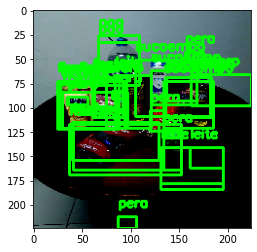

In [ ]:
from google.colab.patches import cv2_imshow
# clone the original image so that we can draw on it
clone = test_img.copy()
i = 0
# loop over the bounding boxes and associated probabilities
for (box, prob) in zip(boxes, proba):
	# draw the bounding box, label, and probability on the image
	(startX, startY, endX, endY) = box
	i = i + 1
	
	y = startY - 10 if startY - 10 > 10 else startY + 10

	area = (endY - startY) * (endX - startX)
	#text= "Raccoon: {:.2f}%".format(prob * 100)
	#text="teste"
	[tmp_prob, tmp_label] = max_prob_label(prob, lb.classes_)
	text = tmp_label
	#print(tmp_prob)
	if (tmp_prob > 0.5 and area < 15000):
	  print("index: ", i, ", prob: ", tmp_prob, ", area: ", area)
	  cv2.rectangle(clone, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
	  cv2.putText(clone, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

#clone = img_to_array(clone)
#clone = preprocess_input(clone)


# show the output after *before* running NMS
#imshow(clone)
plt.imshow(clone)

In [ ]:
#Código dessa célula por Coutinho
def NMS(B, S, Nt, soft=False):
  D  = []
  Sd = []

  B = list(B)
  S = list(S)

  while len(B) != 0:
    #B_S = list(zip(B, S))
    max_index = S.index(max(S))
    m = S[max_index] #sorted(B_S, key= lambda x: x[1],reverse=True)[0][1]
    M = B[max_index] #sorted(B_S, key= lambda x: x[1],reverse=True)[0][0]
    D.append(M)
    B.pop(max_index)
    Sd.append(m)
    S.pop(max_index)
    index = -1
    for b in B:
      #index = B.index(b)
      if len(B) == 0:
        break;
      index = index + 1
      print("index=",index)
      print("M=",M)
      print("b=",b)
      if soft:
        S[index] -= IOU(M['box'],b)['box']
      else:
        #if IOU(M['box'],b['box']) > Nt:
        if IOU(M, b) > Nt:
          B.pop(index)
          S.pop(index)

  return D, Sd

def IOU(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
  # boxA= (boxA[0],boxA[1], boxA[0] + width, boxA[1] + height)
  # boxB= (boxB[0],boxB[1], boxB[0] + width, boxB[1] + height)
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])
  # compute the area of intersection rectangle
  interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = interArea / float(boxAArea + boxBArea - interArea)
  # return the intersection over union value
  return iou
     



In [ ]:
NMS(boxes, scores, 0.3)

index= 0
M= [ 77  33 120 115]
b= [ 62 121  91 137]
index= 1
M= [ 77  33 120 115]
b= [136  69 182 109]
index= 2
M= [ 77  33 120 115]
b= [  0  75  38 104]
index= 3
M= [ 77  33 120 115]
b= [ 72 121 129 136]
index= 4
M= [ 77  33 120 115]
b= [111  48 156  81]
index= 5
M= [ 77  33 120 115]
b= [ 28  70  98 101]
index= 6
M= [ 77  33 120 115]
b= [134  73 185 121]
index= 7
M= [ 77  33 120 115]
b= [  0  51 182 121]
index= 8
M= [ 77  33 120 115]
b= [35 86 56 97]
index= 9
M= [ 77  33 120 115]
b= [ 34 193  58 224]
index= 10
M= [ 77  33 120 115]
b= [176 141 192 151]
index= 11
M= [ 77  33 120 115]
b= [105  51 162  95]
index= 12
M= [ 77  33 120 115]
b= [31 70 73 75]
index= 13
M= [ 77  33 120 115]
b= [121  66 187 124]
index= 14
M= [ 77  33 120 115]
b= [ 67 172 201 224]
index= 15
M= [ 77  33 120 115]
b= [ 71  90  97 103]
index= 16
M= [ 77  33 120 115]
b= [121  66 187 127]
index= 17
M= [ 77  33 120 115]
b= [  0  68 224 224]
index= 18
M= [ 77  33 120 115]
b= [125  91 150 118]
index= 19
M= [ 77  33 120 115]

IndexError: ignored

In [ ]:
def non_max_suppression_slow(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# initialize the list of picked indexes
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
 
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list, add the index
		# value to the list of picked indexes, then initialize
		# the suppression list (i.e. indexes that will be deleted)
		# using the last index
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		suppress = [last]
    		# loop over all indexes in the indexes list
		for pos in range(0, last):
			# grab the current index
			j = idxs[pos]
			#print(j)
			# find the largest (x, y) coordinates for the start of
			# the bounding box and the smallest (x, y) coordinates
			# for the end of the bounding box
			xx1 = max(x1[i], x1[j])
			yy1 = max(y1[i], y1[j])
			xx2 = min(x2[i], x2[j])
			yy2 = min(y2[i], y2[j])
			# compute the width and height of the bounding box
			w = max(0, xx2 - xx1 + 1)
			h = max(0, yy2 - yy1 + 1)
			# compute the ratio of overlap between the computed
			# bounding box and the bounding box in the area list
			overlap = float(w * h) / area[j]
			# if there is sufficient overlap, suppress the
			# current bounding box
			if overlap > overlapThresh:
				suppress.append(pos)
		# delete all indexes from the index list that are in the
		# suppression list
		idxs = np.delete(idxs, suppress)
	# return only the bounding boxes that were picked
	return boxes[pick]
	#return idxs

In [ ]:
boxes.shape

(305, 4)

In [ ]:
boxIdxs = non_max_suppression_slow(boxes, 0.3)

In [ ]:
print(boxIdxs)

[[  0  65 224 224]
 [196  11 224  82]
 [ 67  33 109  77]
 [155  43 183  55]
 [ 64   0  85  10]]


In [ ]:
def find_labels(boxIdxs, boxes, proba):
  tmp_labels = []
  for b_i in boxIdxs:
    #print(b_i)
    for b_j, prob_j in zip(boxes, proba):
      if (b_i[0] == b_j[0] and b_i[1] == b_j[1]  and b_i[2] == b_j[2]  and b_i[3] == b_j[3]):
        tmp_label = max_prob_label(prob_j, lb.classes_)
        #print(tmp_label)
        tmp_labels.append(tmp_label)
        break
  return tmp_labels


In [ ]:
print(lb.classes_)

['agua' 'banana' 'caixachocolate' 'cha' 'detergente' 'feijao' 'fosforo'
 'leite' 'leitecondensado' 'maionese' 'oleo' 'pao' 'pera' 'refrigerante'
 'sucoempo']


In [ ]:
print(proba[3])

[0.02707874 0.03221949 0.04405431 0.040933   0.19834368 0.02052372
 0.07923278 0.1412155  0.07235695 0.00547327 0.02504686 0.04057581
 0.107503   0.07689246 0.08855056]


In [ ]:
labels_after_nms = find_labels(boxIdxs, boxes, proba)

In [ ]:
labels_after_nms

[[0.19563779, 'sucoempo'],
 [0.5517264, 'pera'],
 [0.24402809, 'pera'],
 [0.30023518, 'leite'],
 [0.3113449, 'pera'],
 [0.3250458, 'detergente'],
 [0.58472496, 'pao'],
 [0.4347448, 'pera'],
 [0.4223291, 'pera']]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0 175  42 224]
[ 87 212 106 224]
[131 205 173 224]
[113 172 201 224]
[131 167 224 224]
[  0 170  58 224]
[ 67 186 177 224]
[  0 175 105 224]
[  0  66 224 224]
[  0   0 224 224]


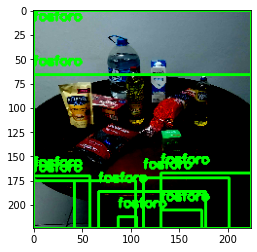

In [ ]:
clone = test_img.copy()
selected_boxes = non_max_suppression_slow(boxes, 0.8)
# loop over the bounding box indexes
for tmp_box in selected_boxes:
	print(tmp_box)
	#continue
	# draw the bounding box, label, and probability on the image
	(startX, startY, endX, endY) = tmp_box
	#continue
	cv2.rectangle(clone, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
	y = startY - 10 if startY - 10 > 10 else startY + 10
	#text= "Raccoon: {:.2f}%".format(proba[i] * 100)
	cv2.putText(clone, text, (startX, y),
		cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
# show the output image *after* running NMS
#cv2.imshow("After NMS", image)
plt.imshow(clone)